In [1]:
from scipy.special import jv, jn_zeros, jvp
from scipy.integrate import dblquad
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def l(n, k):
    return jn_zeros(n, k)[-1]

basis = {}
norms_squared = {}
for k in range(1, 5):
    basis[0, k] = lambda r, p, k_=k: jv(0, l(0, k_) * r)
    norms_squared[0, k] = np.pi * jvp(0, l(0, k))**2

for n in range(-10, 11):
    if n==0: continue
    for k in range(1, 11):
        nabs = np.abs(n)
        if n > 0:
            basis[n, k] = lambda r, p, n_=nabs, k_=k: jv(n_, l(n_, k_) * r) * np.cos(n_ * p)
        else:
            basis[n, k] = lambda r, p, n_=nabs, k_=k: jv(n_, l(n_, k_) * r) * np.sin(n_ * p)

        norms_squared[n, k] = np.pi/2 * jvp(n, l(n, k))**2

In [4]:
def f(r, p):
    # return np.cos(r * 3 * np.pi/2)
    return jv(1, l(1, 2) * r) * np.cos(p)

inhomogeneous_expansion = {}
for nk in tqdm(basis.keys()):
    integral = lambda r, p: r * f(r, p) * basis[nk](r, p)
    integral, error = dblquad(integral, a=0, b=2*np.pi, gfun=0, hfun=1)
    integral *= 1 / norms_squared[nk]
    inhomogeneous_expansion[nk] = integral

  0%|          | 0/204 [00:00<?, ?it/s]

100%|██████████| 204/204 [01:51<00:00,  1.84it/s]


In [5]:
def evaluate_u(r, p):
    res = 0
    for nk in basis.keys():
        res += inhomogeneous_expansion[nk] / (1 - l(*nk)**2) * basis[nk](r, p)
    return res

def evaluate_f(r, p):
    res = 0
    for nk in basis.keys():
        res += inhomogeneous_expansion[nk] * basis[nk](r, p)
    return res

pt = (0.5, np.pi/1)
f(*pt) - evaluate_f(*pt)

-8.326672684688674e-17

In [6]:
data = {'r': [], 'p': []}

for r in np.linspace(0, 1, 100, endpoint=True):
    for p in np.linspace(0, 2*np.pi, 100, endpoint=False):
        data['r'].append(r)
        data['p'].append(p)
df = pd.DataFrame(data)
df['x'] = df['r'] * np.cos(df['p'])
df['y'] = df['r'] * np.sin(df['p'])
df['u'] = df.apply(lambda row: evaluate_u(row['r'], row['p']), axis=1)
df['f'] = df.apply(lambda row: f(row['r'], row['p']), axis=1)

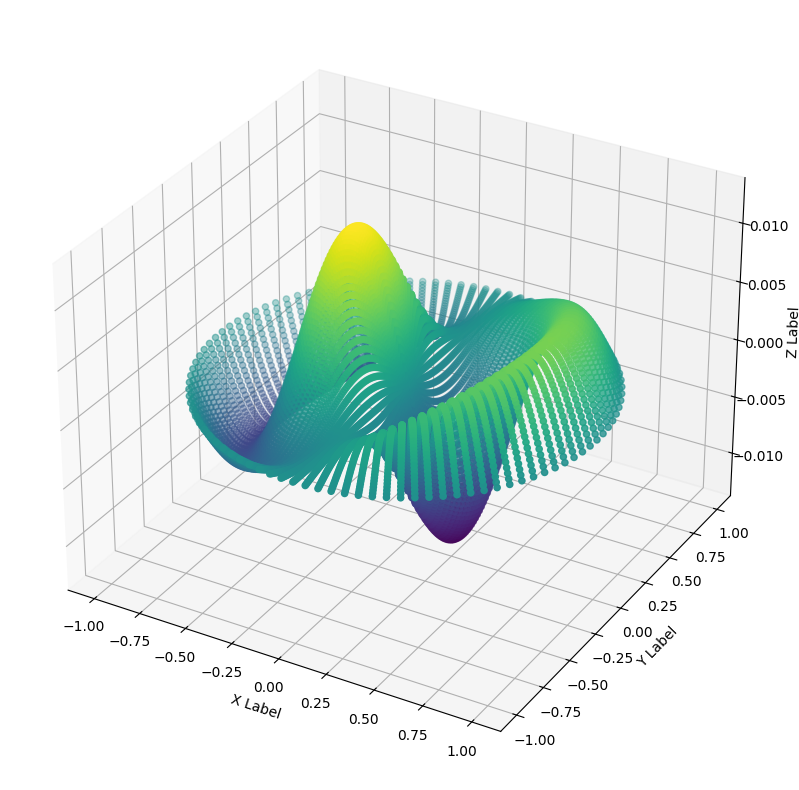

In [8]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(df['x'], df['y'], df['u'], c=df['u'], marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [3]:
import pickle
df = pickle.load(open('df.pkl', 'rb'))